# 1-4,时间序列数据建模流程范例

2020年发生的新冠肺炎疫情灾难给各国人民的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

本文基于中国2020年3月之前的疫情数据，建立时间序列RNN模型，对中国的新冠肺炎疫情结束时间进行预测。

In [1]:
import torch 
print("torch.__version__ = ", torch.__version__)



torch.__version__ =  2.5.1


<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


## 一，准备数据

本文的数据集取自tushare，获取该数据集的方法参考了以下文章。

《https://zhuanlan.zhihu.com/p/109556102》

![](./data/1-4-新增人数.png)


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

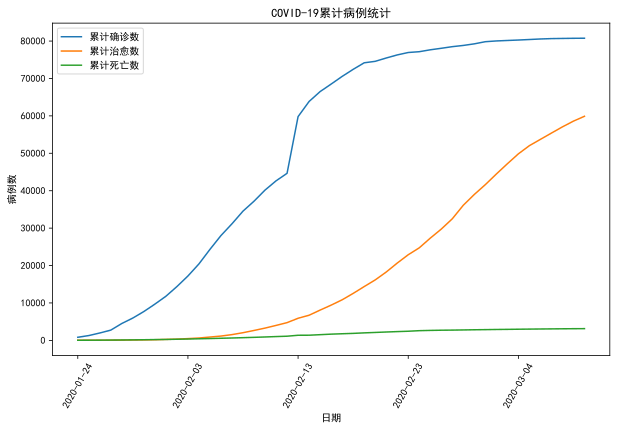

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import pandas as pd

# 配置中文字体，解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取COVID-19数据集
covidData = pd.read_csv("./eat_pytorch_datasets/covid-19.csv", sep="\t")

# 绘制COVID-19累计病例折线图
covidData.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(10, 6))

# 设置x轴日期标签旋转60度
plt.xticks(rotation=60)

# 添加图表标题和轴标签
plt.title("COVID-19累计病例统计")
plt.xlabel("日期")
plt.ylabel("病例数")

# 添加图例
plt.legend(["累计确诊数", "累计治愈数", "累计死亡数"])

# 显示图表
plt.show()

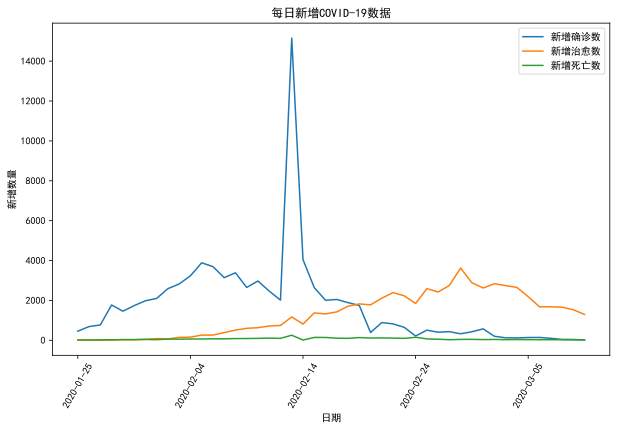

In [4]:
# 读取数据，假设 df 已经存在
# df = pd.read_csv("./eat_pytorch_datasets/covid-19.csv", sep="\t")

# 将日期列设置为索引
covidData = covidData.set_index("date")

# 计算每日新增数据，并删除第一行（因为第一行没有前一天的数据，diff结果为NaN）
dailyNewCases = covidData.diff(periods=1).dropna()

# 将索引重置为列，以便绘制图形
dailyNewCases = dailyNewCases.reset_index("date")

# 绘制每日新增数据的折线图
dailyNewCases.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(10, 6))

# 设置x轴刻度标签旋转60度
plt.xticks(rotation=60)

# 删除日期列，并将剩余列的数据类型转换为 float32，以便后续处理
dailyNewCases = dailyNewCases.drop("date", axis=1).astype("float32")

# 添加标题
plt.title("每日新增COVID-19数据")

# 添加x轴标签
plt.xlabel("日期")

# 添加y轴标签
plt.ylabel("新增数量")

# 添加图例
plt.legend(["新增确诊数", "新增治愈数", "新增死亡数"])

# 显示图形
plt.show()

In [5]:
dailyNewCases.head()

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


下面我们通过继承torch.utils.data.Dataset实现自定义时间序列数据集。

torch.utils.data.Dataset是一个抽象类，用户想要加载自定义的数据只需要继承这个类，并且覆写其中的两个方法即可：

* `__len__`:实现len(dataset)返回整个数据集的大小。
* `__getitem__`:用来获取一些索引的数据，使`dataset[i]`返回数据集中第i个样本。

不覆写这两个方法会直接返回错误。


In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# 使用过去 WINDOW_SIZE 天的数据作为输入，预测当天的数据
WINDOW_SIZE = 8  # 将 ss 替换为 WINDOW_SIZE，并设置具体数值

class Covid19Dataset(Dataset):

    def __len__(self):
        return len(dailyNewCases) - WINDOW_SIZE  # 假设 dailyNewCases 是之前处理好的 DataFrame

    def __getitem__(self, i):
        x = dailyNewCases.iloc[i:i + WINDOW_SIZE, :]  # 使用 iloc 更清晰地进行索引
        feature = torch.tensor(x.values, dtype=torch.float32)  # 明确指定数据类型
        y = dailyNewCases.iloc[i + WINDOW_SIZE, :]
        label = torch.tensor(y.values, dtype=torch.float32)
        return feature, label

# 创建训练数据集
trainDataset = Covid19Dataset()

# 数据较小，将全部训练数据放入一个 batch 中，提升性能
trainDataLoader = DataLoader(trainDataset, batch_size=len(trainDataset))  # 使用 len(trainDataset) 动态设置 batch_size

# 获取一个 batch 的数据进行示例展示
for features, labels in trainDataLoader:
    break

# 将训练数据加载器同时作为验证集
validationDataLoader = trainDataLoader

## 二，定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器进行封装。

此处选择第二种方式构建模型。

在 PyTorch 中，有几种不同的方式来构建神经网络模型。以下是对这几种方法的介绍和简单的代码示例：

**1. 使用 `nn.Sequential` 按层顺序构建模型**

* **特点：**
    * 这是最简单的方式，适用于层之间是简单顺序连接的模型。
    * 通过将层按顺序放入 `nn.Sequential` 容器中，可以快速构建模型。
    * 它适用于线性的、简单的模型结构。
* **示例代码：**

```python
import torch
import torch.nn as nn

# 使用 nn.Sequential 构建模型
model_sequential = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.Softmax(dim=1)
)

print(model_sequential)
```

**2. 继承 `nn.Module` 基类构建自定义模型**

* **特点：**
    * 这种方式更灵活，可以构建复杂的模型结构。
    * 你需要定义 `__init__` 方法来初始化层，并定义 `forward` 方法来实现前向传播。
    * 适用于复杂的、非线性的模型结构。
* **示例代码：**

```python
import torch
import torch.nn as nn

# 继承 nn.Module 构建自定义模型
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.linear1 = nn.Linear(10, 20)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(20, 5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

model_custom = CustomModel()
print(model_custom)
```

**3. 继承 `nn.Module` 基类构建模型并辅助应用模型容器进行封装**

* **特点：**
    * 这种方式结合了继承 `nn.Module` 的灵活性和模型容器的便利性。
    * 你可以将模型的某些部分封装在 `nn.Sequential` 或 `nn.ModuleList` 等容器中，以便更好地组织代码。
    * 适用于需要模块化和组织复杂模型的情况。
* **示例代码：**

```python
import torch
import torch.nn as nn

# 继承 nn.Module 构建模型并使用模型容器
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 16 * 16, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

model_hybrid = HybridModel()
print(model_hybrid)
```

**总结：**

* `nn.Sequential` 适合简单的顺序模型。
* 继承 `nn.Module` 适合复杂的自定义模型。
* 继承 `nn.Module` 并辅助应用模型容器，适合模块化和组织复杂模型。



In [7]:
import torch
from torch import nn
import torchkeras  # 假设 torchkeras 是一个自定义库

torch.manual_seed(0)  # 设置随机种子，保证实验的可重复性

# 定义一个自定义模块 Block，用于实现特定的增长逻辑
class Block(nn.Module):
    def __init__(self):
        super(Block, self).__init__()

    def forward(self, x, x_input):
        # 实现增长逻辑：(1 + x) * x_input 的最后一个时间步，并截断负值
        x_out = torch.clamp((1 + x) * x_input[:, -1, :], min=0.0)
        return x_out

# 定义一个自定义神经网络模型 Net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义一个 5 层 LSTM 网络，输入和隐藏层大小为 3，batch_first=True
        self.lstm = nn.LSTM(input_size=3, hidden_size=3, num_layers=5, batch_first=True)
        # 定义一个线性层，将 LSTM 的输出映射到 3 个输出
        self.linear = nn.Linear(3, 3)
        # 实例化自定义模块 Block
        self.block = Block()

    def forward(self, x_input):
        # 获取 LSTM 的输出，并取最后一个时间步的输出
        lstm_output, _ = self.lstm(x_input)
        x = lstm_output[:, -1, :]
        # 通过线性层
        x = self.linear(x)
        # 通过自定义模块 Block
        y = self.block(x, x_input)
        return y

# 实例化模型
net = Net()
# 打印模型结构
print(net)

Net(
  (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
  (linear): Linear(in_features=3, out_features=3, bias=True)
  (block): Block()
)


In [8]:
from torchkeras import summary
summary(net,input_data=features);

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
LSTM-1                                    [-1, 8, 3]                  480
Linear-2                                     [-1, 3]                   12
Block-3                                      [-1, 3]                    0
Total params: 492
Trainable params: 492
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000076
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002182
--------------------------------------------------------------------------


在 PyTorch 中，有几种不同的方式来构建神经网络模型。以下是对这几种方法的介绍和简单的代码示例：

**1. 使用 `nn.Sequential` 按层顺序构建模型**

* **特点：**
    * 这是最简单的方式，适用于层之间是简单顺序连接的模型。
    * 通过将层按顺序放入 `nn.Sequential` 容器中，可以快速构建模型。
    * 它适用于线性的、简单的模型结构。
* **示例代码：**

```python
import torch
import torch.nn as nn

# 使用 nn.Sequential 构建模型
model_sequential = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.Softmax(dim=1)
)

print(model_sequential)
```

**2. 继承 `nn.Module` 基类构建自定义模型**

* **特点：**
    * 这种方式更灵活，可以构建复杂的模型结构。
    * 你需要定义 `__init__` 方法来初始化层，并定义 `forward` 方法来实现前向传播。
    * 适用于复杂的、非线性的模型结构。
* **示例代码：**

```python
import torch
import torch.nn as nn

# 继承 nn.Module 构建自定义模型
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.linear1 = nn.Linear(10, 20)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(20, 5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

model_custom = CustomModel()
print(model_custom)
```

**3. 继承 `nn.Module` 基类构建模型并辅助应用模型容器进行封装**

* **特点：**
    * 这种方式结合了继承 `nn.Module` 的灵活性和模型容器的便利性。
    * 你可以将模型的某些部分封装在 `nn.Sequential` 或 `nn.ModuleList` 等容器中，以便更好地组织代码。
    * 适用于需要模块化和组织复杂模型的情况。
* **示例代码：**

```python
import torch
import torch.nn as nn

# 继承 nn.Module 构建模型并使用模型容器
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 16 * 16, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

model_hybrid = HybridModel()
print(model_hybrid)
```

**总结：**

* `nn.Sequential` 适合简单的顺序模型。
* 继承 `nn.Module` 适合复杂的自定义模型。
* 继承 `nn.Module` 并辅助应用模型容器，适合模块化和组织复杂模型。


### 三，训练模型

训练Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处我们通过引入torchkeras库中的KerasModel工具来训练模型，无需编写自定义循环。

torchkeras详情:  https://github.com/lyhue1991/torchkeras 

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。



In [9]:
from torchmetrics.regression import MeanAbsolutePercentageError

# 定义均方百分比误差（MSPE）损失函数
def mspe(y_pred, y_true):
    """
    计算均方百分比误差（MSPE）。

    参数：
        y_pred (Tensor): 预测值。
        y_true (Tensor): 真实值。

    返回：
        Tensor: 均方百分比误差。
    """
    # 计算百分比误差的平方
    err_percent = (y_true - y_pred)**2 / (torch.max(y_true**2, torch.tensor(1e-7)))
    # 返回平均值
    return torch.mean(err_percent)

# 实例化模型（假设 Net 已经定义）
net = Net()

# 定义损失函数为 MSPE
loss_fn = mspe

# 定义评估指标字典，使用 torchmetrics 的 MeanAbsolutePercentageError
metric_dict = {"mape": MeanAbsolutePercentageError()}

# 定义优化器，使用 Adam 算法，学习率为 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# 定义学习率调度器，使用 StepLR，每 10 个 epoch 学习率乘以 0.0001
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)

In [10]:
import os


def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class MetricTracker:
    """指标跟踪器，用于统一管理各种评估指标的计算"""
    
    def __init__(self, metrics_dict):
        """
        Args:
            metrics_dict: 包含指标名称和计算函数的字典
        """
        self.metrics_dict = metrics_dict
        self.running_metrics = {}
        self.sample_count = 0
        
    def update(self, preds, labels):
        """更新指标值
        
        Args:
            preds: 模型预测值
            labels: 真实标签
        
        Returns:
            Dict: 当前批次的指标值
        """
        batch_metrics = {}
        for name, metric_fn in self.metrics_dict.items():
            value = metric_fn(preds, labels).item()
            batch_metrics[name] = value
            
            # 累积计算平均值
            if name not in self.running_metrics:
                self.running_metrics[name] = 0.0
            self.running_metrics[name] += value * len(labels)
            
        self.sample_count += len(labels)
        return batch_metrics
    
    def compute(self):
        """计算累积后的平均指标值
        
        Returns:
            Dict: 平均指标值
        """
        if self.sample_count == 0:
            return {name: 0.0 for name in self.metrics_dict.keys()}
        
        return {name: value / self.sample_count 
                for name, value in self.running_metrics.items()}
    
    def reset(self):
        """重置所有累积的指标值"""
        self.running_metrics = {}
        self.sample_count = 0


class StepRunner:
    """单步训练/评估运行器"""
    
    def __init__(self, net, loss_fn, stage="train", metrics_dict=None, 
                 optimizer=None, device=None, use_amp=False):
        """
        Args:
            net: 神经网络模型
            loss_fn: 损失函数
            stage: 阶段，'train'或'val'
            metrics_dict: 评估指标字典
            optimizer: 优化器（仅在训练时需要）
            device: 运行设备
            use_amp: 是否使用混合精度训练
        """
        self.net = net
        self.loss_fn = loss_fn
        self.stage = stage
        self.metrics = MetricTracker(metrics_dict or {})
        self.optimizer = optimizer
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.use_amp = use_amp and torch.cuda.is_available()
        self.scaler = torch.cuda.amp.GradScaler() if self.use_amp else None
        
    def step(self, features, labels):
        """执行一步训练或评估
        
        Args:
            features: 输入特征
            labels: 目标标签
            
        Returns:
            Tuple: (损失值, 指标字典)
        """
        # 将数据移动到指定设备
        if isinstance(features, torch.Tensor):
            features = features.to(self.device)
        if isinstance(labels, torch.Tensor):
            labels = labels.to(self.device)
            
        # 使用自动混合精度
        if self.use_amp and self.stage == "train":
            with torch.cuda.amp.autocast():
                preds = self.net(features)
                loss = self.loss_fn(preds, labels)
                
            # 训练阶段：反向传播和优化
            if self.optimizer is not None:
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
        else:
            # 常规前向传播
            preds = self.net(features)
            loss = self.loss_fn(preds, labels)
            
            # 训练阶段：反向传播和优化
            if self.optimizer is not None and self.stage == "train":
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

        # 计算批次指标
        batch_metrics = self.metrics.update(preds, labels)
        step_metrics = {f"{self.stage}_{name}": value for name, value in batch_metrics.items()}
        
        return loss.item(), step_metrics

    def train_step(self, features, labels):
        """执行一步训练
        
        Args:
            features: 输入特征
            labels: 目标标签
            
        Returns:
            Tuple: (损失值, 指标字典)
        """
        self.net.train()
        return self.step(features, labels)

    @torch.no_grad()
    def eval_step(self, features, labels):
        """执行一步评估
        
        Args:
            features: 输入特征
            labels: 目标标签
            
        Returns:
            Tuple: (损失值, 指标字典)
        """
        self.net.eval()
        return self.step(features, labels)

    def __call__(self, features, labels):
        """执行单步
        
        Args:
            features: 输入特征
            labels: 目标标签
            
        Returns:
            Tuple: (损失值, 指标字典)
        """
        if self.stage == "train":
            return self.train_step(features, labels)
        else:
            return self.eval_step(features, labels)


class EpochRunner:
    """整个epoch的训练/评估运行器"""
    
    def __init__(self, steprunner):
        """
        Args:
            steprunner: StepRunner实例
        """
        self.steprunner = steprunner
        self.stage = steprunner.stage

    def __call__(self, dataloader):
        """执行一个epoch的训练或评估
        
        Args:
            dataloader: 数据加载器
            
        Returns:
            Dict: 包含损失和指标的字典
        """
        total_loss, step = 0, 0
        # 创建进度条
        loop = tqdm(enumerate(dataloader), total=len(dataloader), file=sys.stdout)
        
        for i, batch in loop:
            # 执行单步训练或评估
            loss, step_metrics = self.steprunner(*batch)
            
            # 更新累积损失和步数
            total_loss += loss
            step += 1
            
            # 更新进度条
            if i != len(dataloader) - 1:
                loop.set_postfix(**step_metrics)
            else:
                # 计算整个epoch的平均指标
                epoch_loss = total_loss / step
                epoch_metrics = self.steprunner.metrics.compute()
                epoch_log = {
                    f"{self.stage}_loss": epoch_loss, 
                    **{f"{self.stage}_{name}": value for name, value in epoch_metrics.items()}
                }
                loop.set_postfix(**epoch_log)
                
                # 重置指标计算器
                self.steprunner.metrics.reset()
                
        return epoch_log


def train_model(
    net, 
    optimizer, 
    loss_fn, 
    metrics_dict, 
    train_data, 
    val_data=None, 
    epochs=10, 
    ckpt_path='checkpoint.pt', 
    patience=5, 
    monitor="val_loss", 
    mode="min",
    scheduler=None, # 添加 scheduler 参数
    device=None,
    use_amp=False
):
    """通用模型训练函数
    
    Args:
        net: 神经网络模型
        optimizer: 优化器
        loss_fn: 损失函数
        metrics_dict: 评估指标字典
        train_data: 训练数据加载器
        val_data: 验证数据加载器（可选）
        epochs: 训练轮数
        ckpt_path: 检查点保存路径
        patience: 早停耐心值
        monitor: 监控的指标名称
        mode: 监控模式，'min'或'max'
        scheduler: 学习率调度器（可选）
        device: 运行设备
        use_amp: 是否使用混合精度训练
        
    Returns:
        pd.DataFrame: 训练历史记录
    """
    # 确定设备
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    printlog(f"Training on device: {device}")
    net = net.to(device)
    
    # 初始化训练历史记录
    history = {}
    best_score = float('inf') if mode == "min" else float('-inf')
    counter = 0  # 早停计数器
    
    # 开始训练循环
    for epoch in range(1, epochs + 1):
        printlog(f"Epoch {epoch} / {epochs}")
        
        # 1. 训练阶段
        train_step_runner = StepRunner(
            net=net, 
            stage="train", 
            loss_fn=loss_fn, 
            metrics_dict=deepcopy(metrics_dict), 
            optimizer=optimizer,
            device=device,
            use_amp=use_amp
        )
        train_epoch_runner = EpochRunner(train_step_runner)
        train_metrics = train_epoch_runner(train_data)
        
        # 记录训练指标
        for name, metric in train_metrics.items():
            history[name] = history.get(name, []) + [metric]
        
        # 2. 验证阶段
        if val_data:
            val_step_runner = StepRunner(
                net=net, 
                stage="val", 
                loss_fn=loss_fn, 
                metrics_dict=deepcopy(metrics_dict),
                device=device
            )
            val_epoch_runner = EpochRunner(val_step_runner)
            with torch.no_grad():
                val_metrics = val_epoch_runner(val_data)
            
            # 记录验证指标
            val_metrics["epoch"] = epoch
            for name, metric in val_metrics.items():
                history[name] = history.get(name, []) + [metric]
            
            # 3. 早停机制
            current_score = val_metrics[monitor]
            improved = (mode == "min" and current_score < best_score) or \
                       (mode == "max" and current_score > best_score)
            
            if improved:
                best_score = current_score
                counter = 0
                # 保存最佳模型
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'score': best_score,
                }, ckpt_path)
                print(f"[INFO] ✓ New best {monitor}: {best_score:.4f} (Epoch {epoch})", file=sys.stderr)
            else:
                counter += 1
                print(f"[INFO] ! {monitor} did not improve from {best_score:.4f}", file=sys.stderr)
                
            if counter >= patience:
                print(f"[INFO] ⚠ Early stopping triggered after {patience} epochs without improvement", file=sys.stderr)
                break
        
        # 更新学习率
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) and val_data:
                scheduler.step(val_metrics[monitor])
            else:
                scheduler.step()
    
    # 加载最佳模型
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, weights_only=True)  # 添加weights_only=True参数
        net.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']} with {monitor}: {checkpoint['score']:.4f}")
    
    return pd.DataFrame(history)

In [12]:
from torchkeras import KerasModel

keras_model = KerasModel(net,
       loss_fn = loss_fn,
       metrics_dict= metric_dict,
       optimizer = optimizer,
       lr_scheduler = lr_scheduler) 

<<<<<< 🐌 cpu is used >>>>>>


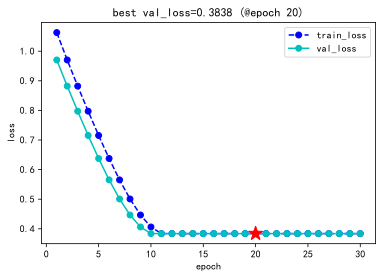

<<<<<< val_loss without improvement in 10 epoch,early stopping >>>>>> 



In [17]:
dfhistory_1 = keras_model.fit(train_data=trainDataLoader,
            val_data=validationDataLoader,
            epochs=100,
            ckpt_path='checkpoint',
            patience=10,
            monitor='val_loss',
            mode='min',
            callbacks=None,
            plot=True,
            cpu=True
            )


这两段代码的区别在于它们传递给 `train_model` 函数的参数方式以及参数的数量。

**第一段代码：**

```python
model = train_model(
    net,
    optimizer,
    loss_fn,
    metric_dict,
    trainDataLoader,
    validationDataLoader,
    scheduler=lr_scheduler
)
```

* **参数传递方式：** 使用位置参数传递。这意味着参数的顺序必须与 `train_model` 函数定义中的顺序完全一致。
* **参数数量：** 传递的参数较少，只包含了 `net`、`optimizer`、`loss_fn`、`metric_dict`、`trainDataLoader`、`validationDataLoader` 和 `scheduler`。其他参数，如 `epochs`、`ckpt_path`、`patience`、`monitor`、`mode` 和 `device`，将使用 `train_model` 函数定义的默认值。

**第二段代码：**

```python
dfhistory = train_model(
    net=net,  # 假设 net 是你的模型实例
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics_dict=metric_dict,
    train_data=trainDataLoader,
    val_data=validationDataLoader,
    epochs=100,
    ckpt_path='checkpoint.pt',  # 注意：这里需要添加 .pt 扩展名
    patience=10,
    monitor='val_loss',
    mode='min',
    scheduler=lr_scheduler, # 添加 lr_scheduler 参数
    device=torch.device('cpu') # 添加 device 参数
)
```

* **参数传递方式：** 使用关键字参数传递。这意味着你可以以任意顺序传递参数，只要你使用正确的参数名称。
* **参数数量：** 传递了所有 `train_model` 函数定义的参数，包括 `epochs`、`ckpt_path`、`patience`、`monitor`、`mode` 和 `device`。这允许你自定义这些参数的值。

**主要区别：**

1.  **灵活性：** 使用关键字参数（第二段代码）更灵活，因为你可以选择性地覆盖某些参数的默认值，而无需关心参数的顺序。
2.  **可读性：** 使用关键字参数可以提高代码的可读性，因为你可以清楚地看到每个参数的值。
3.  **完整性：** 第二段代码明确地设置了所有相关参数，而第一段代码则依赖于 `train_model` 函数的默认值。

**总结：**

在大多数情况下，建议使用关键字参数（第二段代码），因为它更灵活、更易读。但是，如果你确定参数的顺序并且不需要覆盖任何默认值，那么使用位置参数（第一段代码）也是可以的。


### 四，评估模型

评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

In [29]:
# 检查一个批次的格式
for batch in trainDataLoader:
    print("批次类型:", type(batch))
    print("批次长度:", len(batch))
    for i, item in enumerate(batch):
        print(f"项目 {i} 类型:", type(item))
        print(f"项目 {i} 形状:", item.shape)
    break

批次类型: <class 'list'>
批次长度: 2
项目 0 类型: <class 'torch.Tensor'>
项目 0 形状: torch.Size([38, 8, 3])
项目 1 类型: <class 'torch.Tensor'>
项目 1 形状: torch.Size([38, 3])


In [30]:
# 检查模型输出的形状
with torch.no_grad():
    for batch in trainDataLoader:
        inputs = batch[0]  # 假设输入是批次的第一个元素
        outputs = net(inputs)
        print("模型输出形状:", outputs.shape)
        break

模型输出形状: torch.Size([38, 3])


In [33]:
# 添加学习率调度器
# scheduler = torch.optim.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
import datetime
from copy import deepcopy

def rmse(y_pred, y_true):
    """计算均方根误差"""
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

def mae(y_pred, y_true):
    """计算平均绝对误差"""
    return torch.mean(torch.abs(y_pred - y_true))

def r2_score(y_pred, y_true):
    """计算R²决定系数"""
    var_y = torch.var(y_true, unbiased=False)
    mse = torch.mean((y_pred - y_true) ** 2)
    return torch.tensor(1.0) - (mse / var_y)

# 收集评估指标到字典中
metrics_dict = {
    "rmse": rmse,
    "mae": mae,
    "r2": r2_score
}

# 使用带新功能的训练调用
dfhistory_2 = train_model(
    net=net,
    optimizer=optimizer,
    loss_fn=nn.MSELoss(),  # 对于回归任务使用MSE损失
    metrics_dict=metrics_dict,
    train_data=trainDataLoader,
    val_data=validationDataLoader,
    epochs=50,
    ckpt_path='best_model.pt',
    patience=10,
    monitor="val_rmse",  # 监控验证集的RMSE
    mode="min",  # 误差越小越好
    # scheduler=scheduler,  # 取消注释启用学习率调度器
    # use_amp=True  # 取消注释启用混合精度训练
)


================================================================================2025-03-14 23:12:37
Training on device: cpu


================================================================================2025-03-14 23:12:37
Epoch 1 / 50

100%|██████████| 1/1 [00:00<00:00, 93.66it/s, val_loss=2.22e+6, val_mae=484, val_r2=0.272, val_rmse=1.49e+3]

[INFO] ✓ New best val_rmse: 1490.0250 (Epoch 1)




================================================================================2025-03-14 23:12:37
Epoch 2 / 50

100%|██████████| 1/1 [00:00<00:00, 91.15it/s, val_loss=2.22e+6, val_mae=483, val_r2=0.271, val_rmse=1.49e+3]

[INFO] ! val_rmse did not improve from 1490.0250




================================================================================2025-03-14 23:12:37
Epoch 3 / 50

100%|██████████| 1/1 [00:00<00:00, 133.42it/s, val_loss=2.22e+6, val_mae=483, val_r2=0.27, val_rmse=1.49e+3]

[INFO] ! val_rmse did not improve from 1490.0250




================================================================================2025-03-14 23:12:37
Epoch 4 / 50

100%|██████████| 1/1 [00:00<00:00, 45.58it/s, val_loss=2.22e+6, val_mae=481, val_r2=0.271, val_rmse=1.49e+3]

[INFO] ! val_rmse did not improve from 1490.0250




================================================================================2025-03-14 23:12:37
Epoch 5 / 50

100%|██████████| 1/1 [00:00<00:00, 100.27it/s, val_loss=2.22e+6, val_mae=480, val_r2=0.273, val_rmse=1.49e+3]

[INFO] ✓ New best val_rmse: 1488.7904 (Epoch 5)




================================================================================2025-03-14 23:12:37
Epoch 6 / 50

100%|██████████| 1/1 [00:00<00:00, 125.33it/s, val_loss=2.21e+6, val_mae=478, val_r2=0.275, val_rmse=1.49e+3]

================================================================================2025-03-14 23:12:37
Epoch 7 / 50



[INFO] ✓ New best val_rmse: 1486.8494 (Epoch 6)


100%|██████████| 1/1 [00:00<00:00, 100.27it/s, val_loss=2.2e+6, val_mae=476, val_r2=0.277, val_rmse=1.48e+3]

================================================================================2025-03-14 23:12:37
Epoch 8 / 50



[INFO] ✓ New best val_rmse: 1484.5981 (Epoch 7)


100%|██████████| 1/1 [00:00<00:00, 111.41it/s, val_loss=2.2e+6, val_mae=474, val_r2=0.279, val_rmse=1.48e+3]

[INFO] ✓ New best val_rmse: 1482.1783 (Epoch 8)




================================================================================2025-03-14 23:12:37
Epoch 9 / 50

100%|██████████| 1/1 [00:00<00:00, 66.84it/s, val_loss=2.19e+6, val_mae=471, val_r2=0.282, val_rmse=1.48e+3]

================================================================================2025-03-14 23:12:37

[INFO] ✓ New best val_rmse: 1479.7111 (Epoch 9)



Epoch 10 / 50

100%|██████████| 1/1 [00:00<00:00, 111.41it/s, val_loss=2.18e+6, val_mae=468, val_r2=0.284, val_rmse=1.48e+3]

[INFO] ✓ New best val_rmse: 1477.2970 (Epoch 10)




================================================================================2025-03-14 23:12:37
Epoch 11 / 50

100%|██████████| 1/1 [00:00<00:00, 91.16it/s, val_loss=2.18e+6, val_mae=465, val_r2=0.286, val_rmse=1.48e+3]

================================================================================2025-03-14 23:12:38
Epoch 12 / 50



[INFO] ✓ New best val_rmse: 1475.0160 (Epoch 11)


100%|██████████| 1/1 [00:00<00:00, 111.41it/s, val_loss=2.17e+6, val_mae=462, val_r2=0.288, val_rmse=1.47e+3]

[INFO] ✓ New best val_rmse: 1472.9296 (Epoch 12)




================================================================================2025-03-14 23:12:38
Epoch 13 / 50

100%|██████████| 1/1 [00:00<00:00, 111.44it/s, val_loss=2.16e+6, val_mae=458, val_r2=0.29, val_rmse=1.47e+3]

================================================================================2025-03-14 23:12:38
Epoch 14 / 50



[INFO] ✓ New best val_rmse: 1471.0809 (Epoch 13)


100%|██████████| 1/1 [00:00<00:00, 100.28it/s, val_loss=2.16e+6, val_mae=455, val_r2=0.291, val_rmse=1.47e+3]

[INFO] ✓ New best val_rmse: 1469.4971 (Epoch 14)




================================================================================2025-03-14 23:12:38
Epoch 15 / 50

100%|██████████| 1/1 [00:00<00:00, 111.40it/s, val_loss=2.16e+6, val_mae=452, val_r2=0.293, val_rmse=1.47e+3]

[INFO] ✓ New best val_rmse: 1468.1898 (Epoch 15)




================================================================================2025-03-14 23:12:38
Epoch 16 / 50

100%|██████████| 1/1 [00:00<00:00, 111.40it/s, val_loss=2.15e+6, val_mae=448, val_r2=0.294, val_rmse=1.47e+3]

================================================================================2025-03-14 23:12:38
Epoch 17 / 50



[INFO] ✓ New best val_rmse: 1467.1582 (Epoch 16)


100%|██████████| 1/1 [00:00<00:00, 64.64it/s, val_loss=2.15e+6, val_mae=445, val_r2=0.294, val_rmse=1.47e+3]

================================================================================2025-03-14 23:12:38

[INFO] ✓ New best val_rmse: 1466.3892 (Epoch 17)



Epoch 18 / 50

100%|██████████| 1/1 [00:00<00:00, 95.42it/s, val_loss=2.15e+6, val_mae=442, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ✓ New best val_rmse: 1465.8607 (Epoch 18)




================================================================================2025-03-14 23:12:38
Epoch 19 / 50

100%|██████████| 1/1 [00:00<00:00, 71.62it/s, val_loss=2.15e+6, val_mae=439, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ✓ New best val_rmse: 1465.5433 (Epoch 19)




================================================================================2025-03-14 23:12:38
Epoch 20 / 50

100%|██████████| 1/1 [00:00<00:00, 112.67it/s, val_loss=2.15e+6, val_mae=436, val_r2=0.295, val_rmse=1.47e+3]


[INFO] ✓ New best val_rmse: 1465.4020 (Epoch 20)



================================================================================2025-03-14 23:12:38
Epoch 21 / 50

100%|██████████| 1/1 [00:00<00:00, 100.27it/s, val_loss=2.15e+6, val_mae=434, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ✓ New best val_rmse: 1465.3988 (Epoch 21)




================================================================================2025-03-14 23:12:38
Epoch 22 / 50

100%|██████████| 1/1 [00:00<00:00, 111.42it/s, val_loss=2.15e+6, val_mae=432, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ! val_rmse did not improve from 1465.3988




================================================================================2025-03-14 23:12:38
Epoch 23 / 50

100%|██████████| 1/1 [00:00<00:00, 125.35it/s, val_loss=2.15e+6, val_mae=429, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ! val_rmse did not improve from 1465.3988




================================================================================2025-03-14 23:12:38
Epoch 24 / 50

100%|██████████| 1/1 [00:00<00:00, 100.28it/s, val_loss=2.15e+6, val_mae=428, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ! val_rmse did not improve from 1465.3988




================================================================================2025-03-14 23:12:38
Epoch 25 / 50

100%|██████████| 1/1 [00:00<00:00, 40.91it/s, val_loss=2.15e+6, val_mae=426, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ! val_rmse did not improve from 1465.3988




================================================================================2025-03-14 23:12:38
Epoch 26 / 50

100%|██████████| 1/1 [00:00<00:00, 83.56it/s, val_loss=2.15e+6, val_mae=425, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ! val_rmse did not improve from 1465.3988




================================================================================2025-03-14 23:12:38
Epoch 27 / 50

100%|██████████| 1/1 [00:00<00:00, 65.26it/s, val_loss=2.15e+6, val_mae=423, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ! val_rmse did not improve from 1465.3988




================================================================================2025-03-14 23:12:38
Epoch 28 / 50

100%|██████████| 1/1 [00:00<00:00, 111.40it/s, val_loss=2.15e+6, val_mae=423, val_r2=0.294, val_rmse=1.47e+3]

[INFO] ! val_rmse did not improve from 1465.3988




================================================================================2025-03-14 23:12:38
Epoch 29 / 50

100%|██████████| 1/1 [00:00<00:00, 100.26it/s, val_loss=2.15e+6, val_mae=422, val_r2=0.294, val_rmse=1.47e+3]

[INFO] ! val_rmse did not improve from 1465.3988




================================================================================2025-03-14 23:12:38
Epoch 30 / 50

100%|██████████| 1/1 [00:00<00:00, 111.41it/s, val_loss=2.15e+6, val_mae=422, val_r2=0.295, val_rmse=1.47e+3]

[INFO] ! val_rmse did not improve from 1465.3988




================================================================================2025-03-14 23:12:38
Epoch 31 / 50

100%|██████████| 1/1 [00:00<00:00, 117.87it/s, val_loss=2.15e+6, val_mae=421, val_r2=0.295, val_rmse=1.47e+3]
Loaded best model from epoch 21 with val_rmse: 1465.3988


[INFO] ! val_rmse did not improve from 1465.3988
[INFO] ⚠ Early stopping triggered after 10 epochs without improvement


In [32]:
keras_model.evaluate(validationDataLoader)

100%|████████████████████████████████| 1/1 [00:00<00:00, 125.40it/s, val_loss=0.393, val_mape=0.516]


{'val_loss': 0.39339613914489746, 'val_mape': 0.5158841609954834}

### 五，使用模型

此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [ ]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dailyNewCases[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [ ]:
#预测此后1000天的新增走势,将其结果添加到dfresult中
for i in range(1000):
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-38:,:]),axis=0)
    arr_predict = keras_model.forward(arr_input)

    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(),
                columns = dfresult.columns)
    dfresult = pd.concat([dfresult,dfpredict],ignore_index=True)
    

In [ ]:
dfresult.query("confirmed_num==0").head()
# 第62天开始新增确诊降为0
# 注：该预测偏乐观


,confirmed_num,cured_num,dead_num
50,0.0,2013.0,0.0
51,0.0,2198.0,0.0
52,0.0,2400.0,0.0
53,0.0,2621.0,0.0
54,0.0,2862.0,0.0


In [ ]:
dfresult.query("cured_num==0").head()
# 第160天开始新增治愈降为0.
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num


### 六，保存模型

模型权重保存在了model.ckpt_path路径。

In [ ]:
#可以加载权重
model.load_ckpt('checkpoint') 

AttributeError: 'DataFrame' object has no attribute 'load_ckpt'

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)